# Import libraries

In [1]:
import os, sys
import tensorflow as tf
import numpy as np
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
# For plotting heap map of confusion matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Mount Google Drive

In [2]:
# Access Google Drive
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


# Function to load training data

In [0]:
def load_dataset(train_folder, image_height, image_width, channels):

  # gets list of .jpg in folder
  jpg_files = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f)) and f.endswith('.jpg')]

  image_files = []
  labels = []

  for file in jpg_files:
    # Files starting with H or N are non-PM: class 0
    if file.startswith('H') or file.startswith('N'):
      image_files.append(file)
      labels.append(0)
    # Files starting with P are PM: class 1
    elif file.startswith('P'):
      image_files.append(file)
      labels.append(1)
    else:
      print("Wrong label, imagen will be discarded.")
    
  images = np.ndarray(shape=(len(image_files), image_height, image_width, channels),
                      dtype=np.float32)
  idx = 0

  for file in image_files:
    image = load_img(train_folder + "/" + file, target_size=(image_height, image_width))
    image_array = img_to_array(image)
    images[idx] = image_array
    idx += 1

  # Convert label list to numpy array
  labels = np.array(labels)

  return images, labels

# Function to preprocess images



In [0]:
def preprocess_images(X_train, y_train, X_val, y_val, batch_size):

  # Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches)
  train_datagen = ImageDataGenerator(
      rescale=1./255,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True)

  # Generator for training set
  train_generator = train_datagen.flow(X_train,
                            y_train,
                            batch_size=batch_size)

  # No data augmentation for validation set
  val_datagen = ImageDataGenerator(rescale=1./255)
  
  # Generator for validation set
  validation_generator = val_datagen.flow(X_val,
                                 y_val,
                                 batch_size=batch_size,
                                 shuffle=False)

  return train_generator, validation_generator

# Function to create and compile model

In [0]:
def get_model(input_shape, loss, optimizer, metrics):

  model = Sequential()

  model.add(Convolution2D(32, 
                        (5, 5), 
                        padding ="same", 
                        input_shape=input_shape, 
                        activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3)))

  model.add(Convolution2D(16, 
                        (2, 2), 
                        padding ="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Convolution2D(16, 
                        (2, 2), 
                        padding ="same"))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(256, 
                activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(1, 
                activation='sigmoid'))
  
  # Compile
  model.compile(loss=loss,
              optimizer=optimizer,
              metrics=metrics)

  model.summary()

  return model

# Variables

In [0]:
# Size of images
image_height, image_width = (256, 256)
# Channels of images: 3 for RGB
channels = 3
input_shape = (image_height, image_width, channels)
# Path to images for training
train_folder = '/gdrive/My Drive/TFG Daniel López Robles/train/'
# Extension of the images of our dataset
file_extesion = '.jpg'
# Number of images for training
n_observations = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f)) and f.endswith('.jpg')])
# Batch size for ImageDataGenerators
batch_size = 32

# Variables for compiling model
loss = 'binary_crossentropy'
learning_rate=0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
metrics = [keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           keras.metrics.AUC(name='auc')]

# Number of folds for stratified k-fold cross validation
CVfolds = 5

# Path to save models
models_path = '/gdrive/My Drive/TFG Daniel López Robles/modelos/'

# Variables for training (model.fit)
steps_per_epoch = ((n_observations // CVfolds) * (CVfolds-1)) // batch_size
epochs = 100
validation_steps = (n_observations // CVfolds) // batch_size
# callbacks
#checkpoint_cb = keras.callbacks.ModelCheckpoint(models_path+'cnn_cross-validation_checkpoint_20200514_1739.h5',
#                                                save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=7,
                                                  restore_best_weights=True)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                              patience=5, min_lr=learning_rate)  
callbacks_list = [early_stopping_cb, reduce_lr]

# 1. Load dataset

In [9]:
# Load dataset
images, labels = load_dataset(train_folder, image_height, image_width, channels)
print("images shape: {} \nlabels shape: {}".format(images.shape, labels.shape))

images shape: (400, 256, 256, 3) 
labels shape: (400,)


# 2. Create and train model

Fold: 1
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      2432      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 16)        2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 42, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 42, 42, 16)        1040      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 21, 21, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7056)       

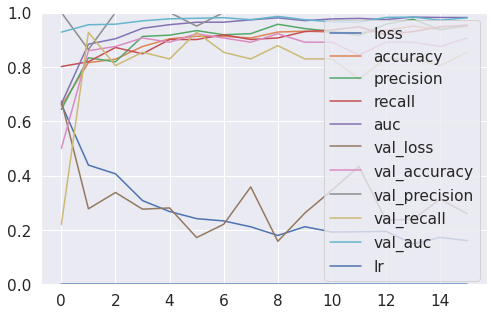

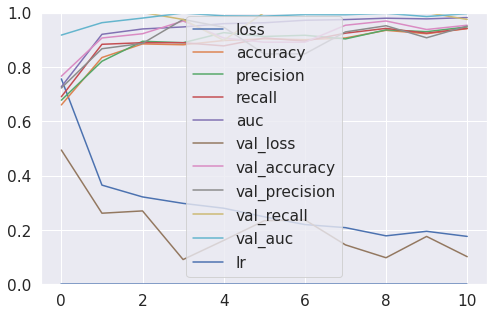

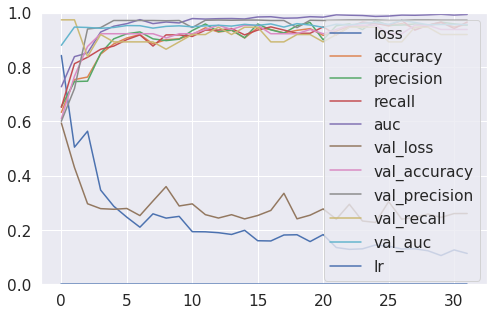

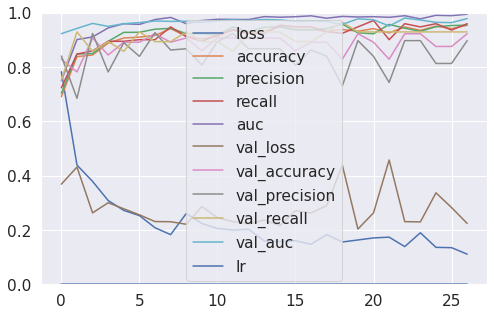

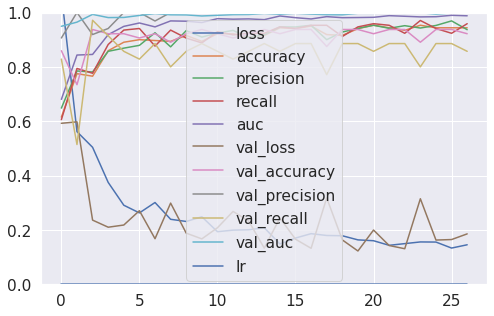

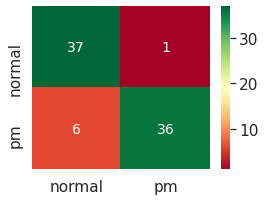

==================== Fold 2 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[16.866  0.925  0.974  0.881  0.927]


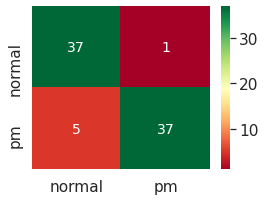

==================== Fold 3 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[35.026  0.887  0.84   0.977  0.88 ]


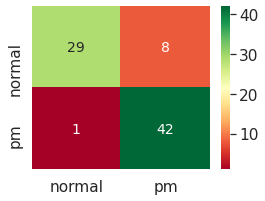

==================== Fold 4 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[30.976  0.887  0.905  0.884  0.888]


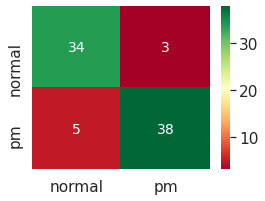

==================== Fold 5 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[13.384  0.95   1.     0.907  0.953]


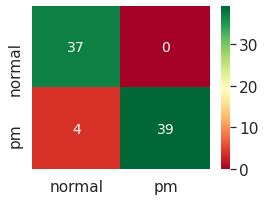

In [13]:
# Matrix for saving scores of model.evaluate for each fold: 
#   rows = number of folds
#   columns = loss + metrics
scores = np.zeros((CVfolds, len(metrics)+1))

# Matrix for saving ground truth and prediction for each fold
folds_y_val = np.zeros((CVfolds, n_observations // CVfolds))
folds_y_pred = np.zeros((CVfolds, n_observations // CVfolds))

skf = StratifiedKFold(n_splits=CVfolds)

for fold, (train_index, val_index) in enumerate(skf.split(images, labels)):
  K.clear_session()
  print("Fold: {}".format(fold+1))
  X_train, X_val = images[train_index], images[val_index]
  y_train, y_val = labels[train_index], labels[val_index]
    
  train_generator, validation_generator = preprocess_images(X_train, y_train, X_val, y_val, batch_size)

  # Create and compile model
  model = get_model(input_shape, loss, optimizer, metrics)

  # Train model
  history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    verbose=1,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks_list)
  
  # Save metrics of model.evaluate for this fold in a row of scores matrix
  #scores[fold] = model.evaluate(X_val, y_val, batch_size=batch_size, steps=validation_steps, verbose=0)
  scores[fold] = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  
  # Save ground truth and predictions for this fold
  folds_y_val[fold] = y_val
  #folds_y_pred[fold] = model.predict(X_val, batch_size=batch_size, steps=validation_steps).flatten()
  folds_y_pred[fold] = model.predict(X_val, batch_size=batch_size).flatten()

  print("===================== SCORES ======================\n{}\n{}\n===================================================".format(model.metrics_names, scores[fold]))

  #model.save(models_path+'cnn1_fold_'+str(fold)+'_20200515.h5')
  #np.save(models_path+'cnn1_fold_'+str(fold)+'_20200515.npy', history.history)

  pd.DataFrame(history.history).plot(figsize=(8, 5))
  plt.grid(True)
  plt.gca().set_ylim(0, 1)
  plt.show

  # Print results
  np.set_printoptions(precision=3)

# Means and standard deviation for model's metrics
print("======================== MODEL MEAN ===========================")
print("{}\n{}".format(model.metrics_names, np.mean(scores, axis=0)))
print("=================== MODEL STANDARD DEVIATION ==================")
print("{}\n{}\n\n".format(model.metrics_names, np.std(scores, axis=0)))

# Metrics per fold
for fold in range(1, CVfolds+1):
  print("==================== Fold {} =========================".format(fold))

  # Scores for this fold
  print("{}\n{}".format(model.metrics_names, scores[fold-1]))
 
  # Confusion matrix
  df_cm = pd.DataFrame(tf.math.confusion_matrix(folds_y_val[fold-1], folds_y_pred[fold-1]).numpy(), index=['normal', 'pm'], columns=['normal', 'pm'])
  plt.figure(figsize=(4,3))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, cmap='RdYlGn', annot=True, annot_kws={"size": 14}) # font size
  plt.show()

# 3. Print metrics and confusion matrices

======================== MODEL MEAN ===========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[53.603  0.902  0.901  0.939  0.903]
=================== MODEL STANDARD DEVIATION ==================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[42.44   0.052  0.101  0.05   0.056]


==================== Fold 1 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[27.257  0.962  0.976  0.952  0.963]


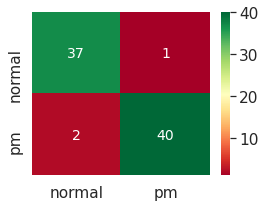

==================== Fold 2 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[53.307  0.863  0.792  1.     0.868]


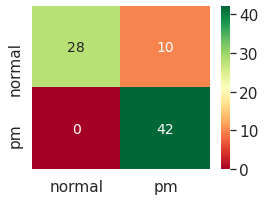

==================== Fold 3 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[47.36   0.913  0.974  0.86   0.917]


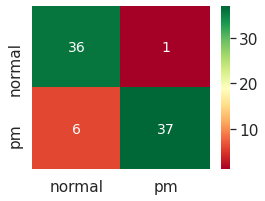

==================== Fold 4 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[132.223   0.825   0.764   0.977   0.813]


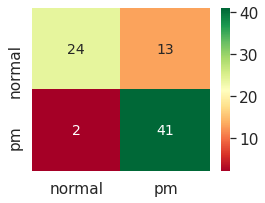

==================== Fold 5 =========================
['loss', 'accuracy', 'precision', 'recall', 'auc']
[7.868 0.95  1.    0.907 0.953]


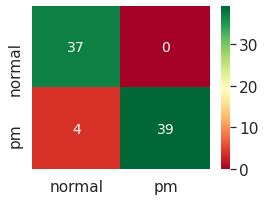

In [11]:
np.set_printoptions(precision=3)

# Means and standard deviation for model's metrics
print("======================== MODEL MEAN ===========================")
print("{}\n{}".format(model.metrics_names, np.mean(scores, axis=0)))
print("=================== MODEL STANDARD DEVIATION ==================")
print("{}\n{}\n\n".format(model.metrics_names, np.std(scores, axis=0)))

# Metrics per fold
for fold in range(1, CVfolds+1):
  print("==================== Fold {} =========================".format(fold))

  # Scores for this fold
  print("{}\n{}".format(model.metrics_names, scores[fold-1]))
 
  # Confusion matrix
  df_cm = pd.DataFrame(tf.math.confusion_matrix(folds_y_val[fold-1], folds_y_pred[fold-1]).numpy(), index=['normal', 'pm'], columns=['normal', 'pm'])
  plt.figure(figsize=(4,3))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(df_cm, cmap='RdYlGn', annot=True, annot_kws={"size": 14}) # font size
  plt.show()